# Malaria cells

In [1]:
from keras import models, layers, optimizers
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import os, shutil

import cv2

Using TensorFlow backend.


## Process data into train, validation, test

In this section we organize the data into train, validation and test sets. We create folders with the corresponding sets. I chose to do it this way instead of importing all of the data and then using the `sk.train_test_split()` method, so that when generating the training and validation data, I could use the `flow_from_directory()` method. This appears to be less expensive in terms of RAM, and seems to be quicker, which is worth the extra code. We seperate the data into 20,000 training samples, 5,558 validation samples and 2000 test samples.

In [2]:
original_data_dir = 'cell-images-for-detecting-malaria/cell_images'
base_dir = 'malaria-detection'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

os.mkdir(train_dir)
os.mkdir(val_dir)
os.mkdir(test_dir)

train_para = os.path.join(train_dir, 'para')
train_uninf = os.path.join(train_dir, 'uninf')
valid_para = os.path.join(val_dir, 'para')
valid_uninf = os.path.join(val_dir, 'uninf')
test_para = os.path.join(test_dir, 'para')
test_uninf = os.path.join(test_dir, 'uninf')

os.mkdir(train_para)
os.mkdir(train_uninf)
os.mkdir(valid_para)
os.mkdir(valid_uninf)
os.mkdir(test_para)
os.mkdir(test_uninf)

para_dir = 'cell-images-for-detecting-malaria/cell_images/Parasitized'
uninf_dir = 'cell-images-for-detecting-malaria/cell_images/Uninfected'

src_file = os.listdir(path=para_dir)
i=0
for filename in src_file:
    if i < 10000:
        src = os.path.join(para_dir, filename)
        dst = os.path.join(train_para, filename)
        shutil.copyfile(src, dst)
    elif 10000 <= i < 11000:
        src = os.path.join(para_dir, filename)
        dst = os.path.join(test_para, filename)
        shutil.copyfile(src, dst)
    else:
        src = os.path.join(para_dir, filename)
        dst = os.path.join(valid_para, filename)
        shutil.copyfile(src, dst)
    i+=1
        
src_file = os.listdir(path=uninf_dir)
i=0
for filename in src_file:
    if i < 10000:
        src = os.path.join(uninf_dir, filename)
        dst = os.path.join(train_uninf, filename)
        shutil.copyfile(src, dst)
    elif 10000 <= i < 11000:
        src = os.path.join(uninf_dir, filename)
        dst = os.path.join(test_uninf, filename)
        shutil.copyfile(src, dst)
    else:
        src = os.path.join(uninf_dir, filename)
        dst = os.path.join(valid_uninf, filename)
        shutil.copyfile(src, dst)
    i+=1

## Viewing some cells

Let's compare some parasitized cells with some uninfected cells.

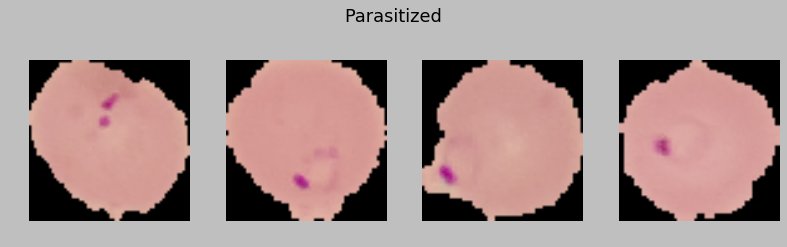

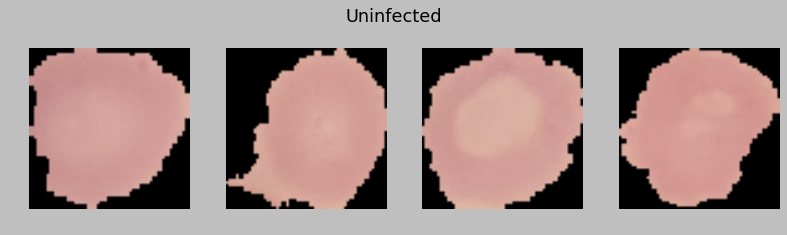

In [4]:
fnames_para = [os.path.join(train_para, fname) for fname in os.listdir(train_para)]
img_paths_para = fnames_para[1:9]

plt.figure(figsize = (10,8))
i=1
for img_path in img_paths_para:
    plt.style.use('classic')
    plt.subplot(2,4,i)
    img = image.load_img(img_path, target_size=(64, 64))
    plt.imshow(img)
    plt.tight_layout()
    plt.axis('off')
    i+=1
plt.figtext(0.5, 0.48, "Parasitized", ha='center', va='center', fontsize=16)
plt.show()

fnames_uninf = [os.path.join(train_uninf, fname) for fname in os.listdir(train_uninf)]
img_paths_uninf = fnames_uninf[1:9]

plt.figure(figsize = (10,7))
i=1
for img_path in img_paths_uninf:
    plt.style.use('classic')
    plt.subplot(2,4,i)
    img = image.load_img(img_path, target_size=(64, 64))
    plt.imshow(img)
    plt.tight_layout()
    plt.axis('off')
    i+=1

plt.figtext(0.5, 0.48, "Uninfected", ha='center', va='center', fontsize=16)
plt.show()

It is easy to identify the parasitized cells by observing the little purple dot. It is safe to say therefore, that any NN will be looking for the presence of these purple regions.

## Simple Convnet

We'll first put together a simple convolutional net, and see how it performs. The parameters were chosen based upon decisions made by Hyperas

In [72]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 29, 29, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        9248      
__________

### Data Augmentation

We introduce data augmentation

In [73]:
batch_size=32
num_train = 20000
num_val = 5558

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(64,64),
                                                   batch_size=batch_size,
                                                   class_mode='binary')

validation_generator = test_datagen.flow_from_directory(val_dir,
                                                        target_size=(64,64),
                                                        batch_size=batch_size,
                                                        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5558 images belonging to 2 classes.


In [74]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

In [75]:
best_model_weights = 'best_model_weights.h5'

checkpoint = ModelCheckpoint(best_model_weights,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

earlystop = EarlyStopping(monitor='acc',
                          min_delta=0.01,
                          patience=5)

reduce = ReduceLROnPlateau(monitor='val_loss',
                           factor=0.1,
                           patience=3)

callbacks = [checkpoint,earlystop,reduce]

In [76]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=num_train//batch_size,
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=num_val//batch_size,
                              callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 90s 143ms/step - loss: 0.5373 - acc: 0.7430 - val_loss: 0.3808 - val_acc: 0.8325

Epoch 00001: val_loss improved from inf to 0.38080, saving model to best_model_weights.h5
Epoch 2/10
625/625 [==============================] - 48s 77ms/step - loss: 0.3291 - acc: 0.8647 - val_loss: 0.3561 - val_acc: 0.8463

Epoch 00002: val_loss improved from 0.38080 to 0.35609, saving model to best_model_weights.h5
Epoch 3/10
625/625 [==============================] - 50s 80ms/step - loss: 0.2574 - acc: 0.9020 - val_loss: 0.2046 - val_acc: 0.9212

Epoch 00003: val_loss improved from 0.35609 to 0.20461, saving model to best_model_weights.h5
Epoch 4/10
625/625 [==============================] - 49s 79ms/step - loss: 0.2244 - acc: 0.9160 - val_loss: 0.1890 - val_acc: 0.9289

Epoch 00004: val_loss improved from 0.20461 to 0.18900, saving model to best_model_weights.h5
Epoch 5/10
625/625 [==============================] - 49s 79ms/step - loss: 0.2110 - ac

In [77]:
model.save('malaria_64.h5')

In [5]:
def plot_history(history):
    plt.style.use('ggplot')
    plt.figure(figsize=(12., 8))
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
  
    epochs = range(1, len(acc) + 1)
  
    plt.plot(epochs, acc, 'bx', label="Training acc")
    plt.plot(epochs, val_acc, 'b', label="Validation acc")
    plt.title("Training and validation accuracy")
  
    plt.plot(epochs, loss, 'rx', label="Training loss")
    plt.plot(epochs, val_loss, 'r', label="Validation loss")
    final_loss = history.history['val_loss'][-1]
    final_acc = history.history['val_acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (final_loss, final_acc))
    plt.legend(loc='lower left')
    plt.show()

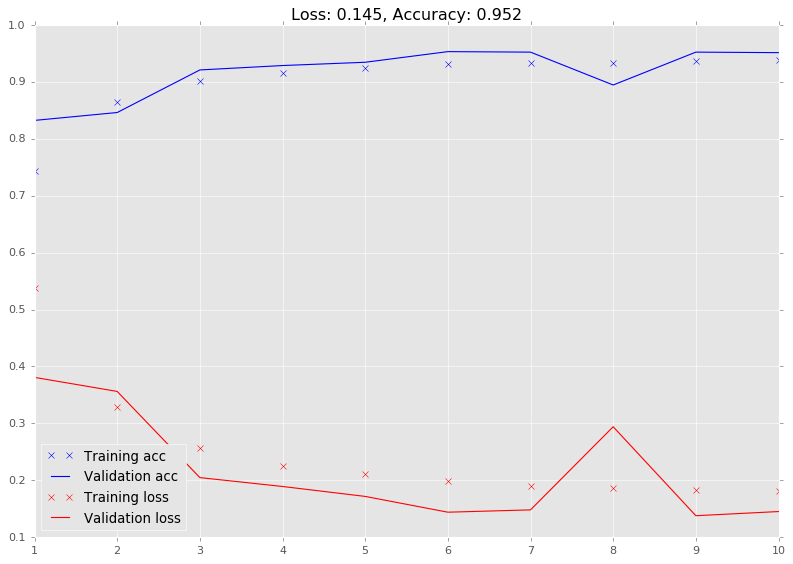

In [78]:
plot_history(history)

In [79]:
#model.load_weights('best_model_weights.h5')
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(64, 64),
                                                  batch_size=batch_size,
                                                  class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=2000//batch_size)
print('test acc:', test_acc)

Found 2000 images belonging to 2 classes.
test acc: 0.9314516129032258


So we get about 93% accuracy on the test set. That's pretty good. Let's have a look at the confusion matrix.

Found 2000 images belonging to 2 classes.


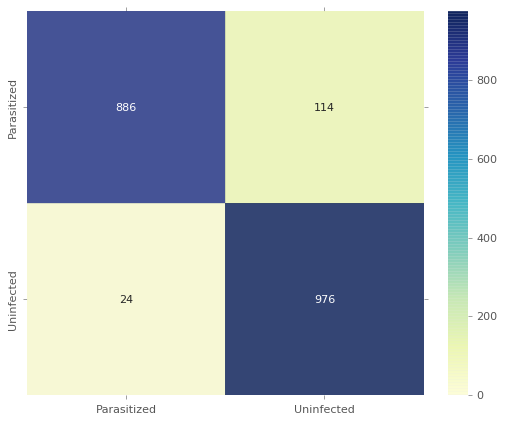

In [80]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(64, 64),
                                                  batch_size=batch_size,
                                                  class_mode=None,
                                                  shuffle=False)

Y_pred = model.predict_generator(test_generator, 2000//batch_size+1)
y_true = test_generator.classes
y_pred = Y_pred > 0.5
sns.heatmap(pd.DataFrame(confusion_matrix(y_true, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0, xticklabels=['Parasitized', 'Uninfected'], yticklabels=['Parasitized', 'Uninfected'])

## Feature extraction using VGG16

Now, we're going to train the VGG16 network on the training set, and then do some feature extraction and feed it into a new network. We'll also pull out the filter textures and check out a heatmap of one sample.

For this version, we'll increase the size of the images to 128 x 128. This is about the upper limit on the images in the training directory. Some will end up getting sized up, and some sized up. Since the ImageNet database really has nothing to do with the cells images, I'm not sure how this is going to go.

In [16]:
from keras.applications import VGG16
inputs = layers.Input(shape=(128,128,3))
conv_base = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [17]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [18]:
x = layers.Flatten()(conv_base.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model2 = models.Model(inputs, x)

### Fine-tuning

In [19]:
batch_size=32
num_train = 20000
num_val = 5558

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(128,128),
                                                   batch_size=batch_size,
                                                   class_mode='binary')

validation_generator = test_datagen.flow_from_directory(val_dir,
                                                        target_size=(128,128),
                                                        batch_size=batch_size,
                                                        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5558 images belonging to 2 classes.


In [22]:
model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

best_model_weights = 'best_model_weights_vgg16.h5'

checkpoint = ModelCheckpoint(best_model_weights,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

earlystop = EarlyStopping(monitor='acc',
                          min_delta=0.01,
                          patience=5)

reduce = ReduceLROnPlateau(monitor='val_loss',
                           factor=0.1,
                           patience=3)

callbacks = [checkpoint,earlystop,reduce]

In [23]:
history = model2.fit_generator(train_generator,
                              steps_per_epoch=num_train//batch_size,
                              epochs=20,
                              validation_data=validation_generator,
                              validation_steps=num_val//batch_size,
                              callbacks=callbacks)

Epoch 1/20
625/625 [==============================] - 99s 158ms/step - loss: 0.2093 - acc: 0.9224 - val_loss: 0.1573 - val_acc: 0.9521

Epoch 00001: val_loss improved from inf to 0.15733, saving model to best_model_weights_vgg16.h5
Epoch 2/20
625/625 [==============================] - 96s 154ms/step - loss: 0.1597 - acc: 0.9440 - val_loss: 0.1602 - val_acc: 0.9534

Epoch 00002: val_loss did not improve from 0.15733
Epoch 3/20
625/625 [==============================] - 96s 154ms/step - loss: 0.1502 - acc: 0.9483 - val_loss: 0.1598 - val_acc: 0.9521

Epoch 00003: val_loss did not improve from 0.15733
Epoch 4/20
625/625 [==============================] - 96s 153ms/step - loss: 0.1451 - acc: 0.9498 - val_loss: 0.1393 - val_acc: 0.9556

Epoch 00004: val_loss improved from 0.15733 to 0.13934, saving model to best_model_weights_vgg16.h5
Epoch 5/20
625/625 [==============================] - 96s 154ms/step - loss: 0.1461 - acc: 0.9521 - val_loss: 0.1433 - val_acc: 0.9485

Epoch 00005: val_loss 

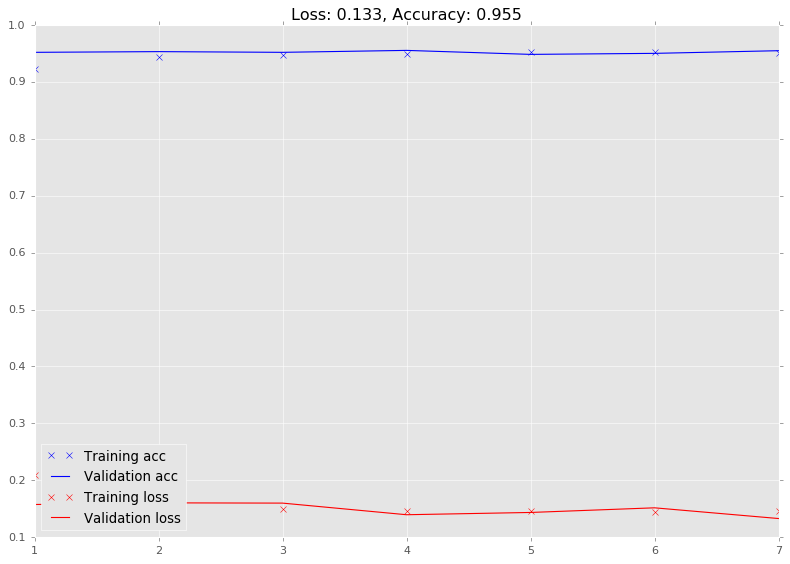

In [24]:
plot_history(history)

In [25]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(128, 128),
                                                  batch_size=batch_size,
                                                  class_mode='binary')

test_loss, test_acc = model2.evaluate_generator(test_generator, steps=2000//batch_size)
print('test acc:', test_acc)

Found 2000 images belonging to 2 classes.
test acc: 0.9390120967741935


Found 2000 images belonging to 2 classes.


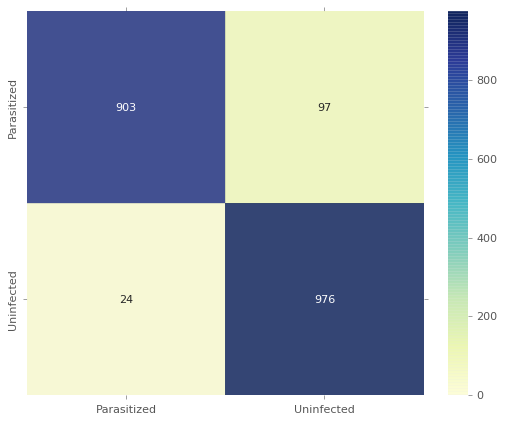

In [26]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(128, 128),
                                                  batch_size=batch_size,
                                                  class_mode=None,
                                                  shuffle=False)

Y_pred = model2.predict_generator(test_generator, 2000//batch_size+1)
y_true = test_generator.classes
y_pred = Y_pred > 0.5
sns.heatmap(pd.DataFrame(confusion_matrix(y_true, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0, xticklabels=['Parasitized', 'Uninfected'], yticklabels=['Parasitized', 'Uninfected'])

In [27]:
model2.save('model_vgg16.h5')

## Heatmap of an image

Now let's have a look at a heatmap of the activations of a layer.

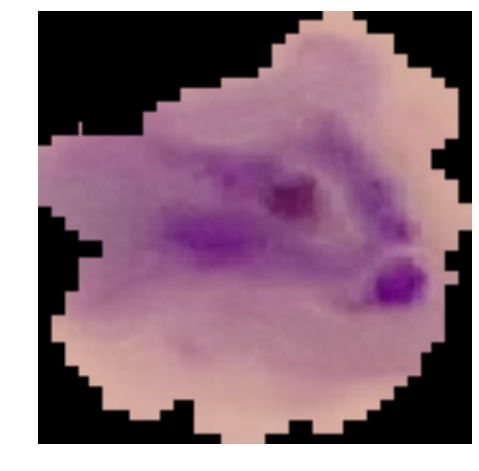

In [68]:
img_path = 'test_cell.png'
img = image.load_img(img_path, target_size=(128,128))
plt.imshow(img)
plt.tight_layout()
plt.axis('off')
plt.show()

In [69]:
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import backend as K

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model2.predict(x)
np.argmax(preds[0])

0

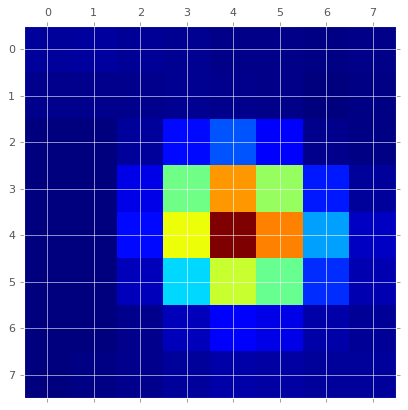

In [70]:
conv_layer = model2.get_layer("block5_conv3")

grads = K.gradients(model2.output[:, 0], conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0,1,2))

iterate = K.function([model2.input], [pooled_grads, conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(64):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

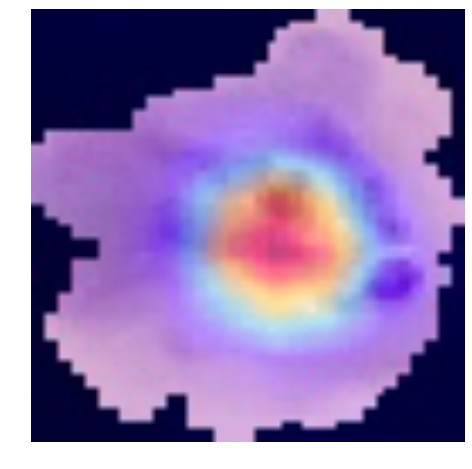

In [71]:
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed = heatmap * 0.4 + img
cv2.imwrite('heatmap.jpg', superimposed)

img_path = 'heatmap.jpg'
img = image.load_img(img_path, target_size=(64,64))
plt.imshow(img)
plt.tight_layout()
plt.axis('off')
plt.show()

Great, so we can see that the network is looking in the center of the cell here, exactly where the infected parts of the cell are.